# Introduction

Welcome to my kernel on time series forecasting to predict the demand on electricty demand in the Great Britain. I will use the historic electricity demand data from the [UK National Grid](https://data.nationalgrideso.com). I will follow the next steps:
* Perform **[EDA and Feature Engineering](#eda)** to clean the dataset, add new features to improve the prediction and understand the trend and seasonality of the electricity demand
* Use **[SARIMA](#sarima)** models to predict electricity demand
    * The SARIMA model requires a variation of the data and its own EDA to estimate the model parameters
* Use **[XGBoost](#xgboost)** models to predict electricity demand
* Use **[Linear Trees](#lienar_trees)** models to predict electricity demand
* Use **[Prophet](#prophet)** models to predict electricity demand
* Use **[LSTM and deep LSTM](#lstm)** recurrent networks to predict electricity demand
* Compare the results from the different models, draw key insights and outline next steps



#  Table of contents
* [EDA and Feature Engineering](#eda_fe)
* [SARIMA](#sarima)
* [XGBoost](#xgboost)
* [Linear Trees](#linear_trees)
* [Prophet](#prophet)
* [LSTM and Deep LSTM](#lstm)

In [ ]:
!pip install pmdarima
!pip install workalendar
!pip install prophet
!pip install -q --upgrade linear-tree

In [ ]:
import datetime
import json
import os
from joblib import Parallel, delayed
from time import sleep, time
import logging


import itertools
import holidays
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import requests
import seaborn as sns
import statsmodels
import statsmodels.tsa.api as sm
import tensorflow as tf
import xgboost as xgb
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from lineartree import LinearBoostRegressor
from matplotlib import rcParams  # Used to set default paremeters
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf, quarter_plot
from workalendar.europe import UnitedKingdom

<a id="eda_fe"></a>
## Figure default parameters

Throughout the notebook I will create manuy figures. In order to save time and avoid having to set the parameters for each plot, I will define the default font and font sizes for all the plots.


In [ ]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

# Load data

I initially used [the National Grid](https://data.nationalgrideso.com) API to acess the historic electricity demand between 2009 and 2022. I uploaded the [dataset](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022) to Kaggle and I will be using it in this notebook.

In [ ]:
df = pd.read_csv("/kaggle/input/electricity-consumption-uk-20092022/historic_demand_2009_2023.csv", index_col=0)

# Change column names to lower case and drop id (row number)
df.columns = df.columns.str.lower()

<a id='eda'></a>
# EDA and Feature engineering

In this section, I will go through several steps to understand and transform the original dataset. The steps I will follow are:
* Data understanding. Have a first look at the timeseries dataset
* Data preparation. Deal with null values, drop uninformative features and remove outliers
* Feature understanding. Understand the trend and different seasonalities in the data

## Data understanding

The [dataset](https://www.kaggle.com/datasets/albertovidalrod/electricity-consumption-uk-20092022) includes a description of all the columns, but for this project I will only use three columns:

* SETTLEMET_DATA: date in format dd/mm/yyyy
* SETTLEMENT_PERIOD: half hourly period for the historic outtunr occurred
* TSD (Transmission System Demand). Transmission System Demand is equal to the ND plus the additional generation required to meet station load, pump storage pumping and interconnector exports. Measured in MW.

TSD is target variable and the aim is to predict the future demand using different models.


Let's have a quick look at the data and the their statistics:

In [ ]:
df.sample(n=7)

In [ ]:
df.describe()

In [ ]:
df.shape

Let's sort the values by date as some of them have been misplaced in the original dataset

In [ ]:
# Sort values by date
df.sort_values(
    by=["settlement_date", "settlement_period"], inplace=True, ignore_index=True
)

## Data preparation

The goal of this section is to prepare the data for the model. To do so, I will perform the following actions:
* Find out how many `nan` values there are and drop the columns containing `nan` values
* Drop rows whose `settlement_period` exceeds 48, as the API states that 48 is the maximum number of samples per day
* Remove outliers

As a bonus, I will add a new feature at this point, bank holidays in the UK. The reason to add them at this point is that I will trasnform the date format for better analysis in a future section. Therefore, it's easier for me to add the bank holidays while performing data preparation.

Let's begin checking if there are`nan` values:

In [ ]:
df.isna().any()

As can be seen, only two columns include `nan` values. Let's check how many `nan` values there are in each column:

In [ ]:
pd.concat(
    [
        df["nsl_flow"].isna().value_counts().to_frame(),
        df["eleclink_flow"].isna().value_counts().to_frame(),
    ],
    axis=1,
    ignore_index=True,
).rename(columns={0: "nsl_flow", 1: "eleclink_flow"})

It seems that both features have the same number of `nan` values. Let's have a look at that the dataframe containing the `nan` value:

In [ ]:
df.loc[(df["eleclink_flow"].isna()) | (df["nsl_flow"].isna()), :]

It seems that neither feature existed from 2009 to 2018. The best thing is to drop these features. 

Also, I will remove the rows where the `settlement_period` exceeds 48, as the maximum number is 48. Any values larger than 48 is a fault when logging the data.

In [ ]:
df.drop(columns=["nsl_flow", "eleclink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

### Bank holidays

Bank holidays are very important in time series forecasting as they often affect the data values on those days. Therefore, I want to add a new column to my dataset to state whether each day was bank holiday or not. I began by checking the [UK governement bank holiday API](https://github.com/alphagov/calendars), but it only goes back to 2015. 

My next option was to check StackOverflow and [oen of the questions](https://stackoverflow.com/questions/37677112/adding-holidays-columns-in-a-dataframe-in-python) was related to this issue. The asnwers suggest using [Python Workalendar](https://workalendar.github.io/workalendar/), but for some reason it was adding more bank holidays than it should (I verified this using other websites). 

Luckily, an entry in [Stack Exchange](https://opendata.stackexchange.com/a/13215) covered this topic too and one of the answers suggested using [Python holidays](https://github.com/dr-prodigy/python-holidays), which after checking the [Python Holidays API](https://python-holidays.readthedocs.io/en/latest/api.html) I managed to make work for my usecase.

Since the dataset covers electricity demand for England and Wales, the first step is to check that the two countries have the same bank holidays:

In [ ]:
# Compare England's and Wales' bank holiday
bank_holiday_england = holidays.UK(
    subdiv="England", years=range(2009, 2024), observed=True
).items()
bank_holiday_wales = holidays.UK(
    subdiv="Wales", years=range(2009, 2024), observed=True
).items()

print(bank_holiday_england == bank_holiday_wales)

Having seen that the bank holidays are the same, I can proceed with this python package to extract the bank holidays and store them in the right format.

It's worth noting that this package includes the original bank holiday and when it was observed. I will only store the observed days.

In [ ]:
# Create empty lists to store data
holiday_names = []
holiday_dates = []
holiday_names_observed = []
holiday_dates_observed = []

for date, name in sorted(bank_holiday_england):
    holiday_dates.append(date)
    holiday_names.append(name)
    # Pop the previous value as observed bank holidays takes place later
    if "Observed" in name:
        holiday_dates_observed.pop()
        holiday_names_observed.pop()

    holiday_names_observed.append(name)
    holiday_dates_observed.append(np.datetime64(date))

holiday_dates_observed[:5]

Once I've verified that the holidays are correctly loaded, one can compare the `holiday_dates` variable and the date in the dataset and store the boolean output in a new column: 

In [ ]:
df["is_holiday"] = df["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)

df["is_holiday"] = df["is_holiday"].astype(int)

df[df["is_holiday"] == 1].sample(7)

The sample dataframe above is ok to make sure that the new column has been created, but one can inspect the bank holidays more easily using a plot.

In [ ]:
# Set date as the index and turn into datetime type
df_plot = df.copy()
df_plot = df_plot.set_index("settlement_date")
df_plot.index = pd.to_datetime(df_plot.index)

fig, ax = plt.subplots(figsize=(15, 5))
df_plot["tsd"].plot(
    style=".", ax=ax, title="Trasnmission System Demand", label="Timeries data"
)
(df_plot.query("is_holiday == 1")["is_holiday"] * 33000).plot(
    style=".", ax=ax, label="Bank holiday"
)
ax.legend();

That plot is great to see the behaviour of the time series data. I can see a decreasing trend and a clear yearly seasonality. However, this plot also shows the presence of data points equal to 0. These values will be removed in the next section.

Before dealing with outliers, in the above graph we can see a yearly trend, but we cannot focus on daily or weekly patterns. Therefore, let's create a new plot focusing on a single week:

In [ ]:
df_plot.loc[(df_plot.index > "01-01-2016") & (df_plot.index < "01-08-2016")][
    "tsd"
].plot(figsize=(10, 5));

This plot isn't what I was expecting... Am I plotting the right parameter or is there something wrong in the dataset? One can begin by inspecting the dataframe:

In [ ]:
df_plot.head()

The plot wasn't wrong! In the process of seeting the date as the index I haven't added the hour. Therefore, the 48 samples per day are overlayed on top of each other.

Before going forward I need to do two things:
* Remove outliers
* Add the hour to the date and set it as the index

### Outlier analysis

In the plot above, one can see that there are multiple 0 values. A histogram will show how many samples are actually equal to 0.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.histplot(data=df, x="tsd", bins=500, ax=ax, color="b");

I will not only delete the values equal to 0 but the entire day where there are values equal to 0. The reason being that otherwise the remaining daily values would not be representative of the entire day, which becomes more relevant for the SARIMA models as I will be using daily data instead of hourly.

In [ ]:
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()

null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

## Feature creation

The first step in the feature creation is to change the date format to include the hourly values. The `settlement_period` values refer to how many samples have been taken per day. Given that there are 48 samples per day, each sample represents 30 minutes of the day. Using this information together with the valuable knowledge of the [StackOverflow](https://stackoverflow.com/questions/61444409/convert-a-pandas-column-to-hours-and-minutes) [contributors](https://stackoverflow.com/questions/51846547/how-to-convert-float-into-hours-minutes-seconds), I managed to change the date format.

In [ ]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.sample(n=7)

As can be seen, a new column called `period_hour` includes the hour at which the electricity demand measurement was taken. One can now combine it with the actual date as follows:

In [ ]:
df["settlement_date"] = pd.to_datetime(
    (df["settlement_date"] + " " + df["period_hour"])
)

df.sample(n=5)

The `settlement_date` column is now in the right format to use an index:

In [ ]:
df.set_index("settlement_date", inplace=True)
df.sort_index(inplace=True)

df.loc[(df.index > "01-01-2016") & (df.index < "01-08-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

While adding extra features will not improve the prediction for the SARIMA models, XGBoost will benefit from it. The new features constits of different bits of information "already stored" in the date, such as the day of the week and the day of the year. Given the seasonality of the time series data, these features might lead to more accurate predictions. The second part is adding lags. Again, XGBoost will benefit from this.

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with new features
    """
    df = df.copy()
    df["day_of_month"] = df.index.day
    df["day_of_week"] = df.index.day_of_week
    df["day_of_year"] = df.index.day_of_year
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["week_of_year"] = df.index.isocalendar().week.astype("int64")
    return df


def add_lags(df):
    """
    Add three lags to the dataset containing information from the previous 3 years.

    Args:
        - df: time series dataframe

    Returns:
        - df: time series dataframe with lags
    """
    target_map = df["tsd"].to_dict()
    # 364 is chosen instead of 365 becuase 364 is divisible by 4 and that way we don't have to
    # map specific days
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [ ]:
df = create_features(df)
df = add_lags(df)

df.sample(n=5)

## Feature understanding

In this section, I will explore the distribution of electricity demand with respect the different features, such as as hour, month or year. This is a great way to understand the seasonalities in the time series.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="settlement_period", y="tsd", data=df)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with hours");

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="tsd", data=df)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with months");

It seems that the lowest consumption occurs during the summer months. Having grown up in Spain, this is a rare concept for me as everyone switches their AC on, resulting in higher consumption.

Let's plot on the years, for example 2016, to make sure that I selected the right variable in the above plot.

In [ ]:
df.loc[(df.index > "01-01-2016") & (df.index < "12-01-2016")]["tsd"].plot(
    figsize=(15, 5), ylabel="Electricity demand (MW)"
);

This plot supports the finding from the previous graph. 

Let's look at the effect of bank holidays on electricity consumption:

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="day_of_week", y="tsd", data=df, hue="is_holiday", ax=ax)

ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
ax.set_xlabel("Day of the week")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Daily Distribution of electricity consumption and holiday effect");

It seems that from Mondat to Friday, the electricity consumption is on average lower on bank holidays, whereas it is higher on Saturday and it's the same on Sundays.

For non bank holiday, the demand on the weekend is lower than during week days.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="year", y="tsd", data=df)

ax.set_xlabel("Year")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption with years");

Although these are yearly average values, one can see a decreasing trend in the electricity consumption. We can overlay the electricity consumption of two years to see how they compare:

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))

ax.plot(
    range(len(df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"])),
    df.loc[(df.index > "01-01-2013") & (df.index < "12-01-2013")]["tsd"],
    "o",
    label="2013",
)

ax.plot(
    range(len(df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"])),
    df.loc[(df.index > "01-01-2021") & (df.index < "12-01-2021")]["tsd"],
    "o",
    alpha=0.5,
    label="2021",
)
ax.set_xlabel("Data sample")
ax.set_ylabel("Electricity demand (MW)")
ax.legend(loc="best")
ax.set_title("Demand comparison - 2013 and 2021");

Again, this plot confirms that electricity consumption is decreasing in recent years.

# Time-series models

Once I've gained enough understanding of the time series data, I'm ready to create different models and check their accuracy on the predictions. In order to compare the results of the models, I will use the Mean Absolute Percentage Error, which I implemented as follows:

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Pertange Error given the true and
    predicted values

    Args:
        - y_true: true values
        - y_pred: predicted values

    Returns:
        - mape: MAPE value for the given predicted values
    """

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

<a id='sarima'></a>
# SARIMA

SARIMA is the first time series forecasting method I will use to predict the electricity demand. I expect this model to perform worse than other methods as there are multiple seasonalitites in the data: daily, weekly and yearly.

In fact, in order to get a decent result, I had to reduce the frequency of the data from twice an hour to daily data. This is nothing but smoothing (filtering) the data and removing what is essentially "noise" in a long time series. My goal is to understand how to tweak the model parameters using autocorrelation plots to increase the accuracy of the model. 

### SARIMA data

The first step to create a SARIMA model is to modify the time series data. I will reduce the frequency of the data to daily summed samples. The reason to use the summed values instead of mean values is that we might see a spike at certain hours of the day that might be masked by the average, whereas summed valuers will show this.

In [ ]:
df_sarima = df["tsd"].resample("D").sum().to_frame()
df_sarima["month"] = df_sarima.index.month
df_sarima["year"] = df_sarima.index.year

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

We can see that the number of samples has been reduced, but most importantly, there are values equal to 0. These values are related to the original `nan` values that were replaced before. While the data for the days containing at least one `nan` value were removed, re-sampling the data using a daily frequency leads to pandas creating those days again and assigning a value equal to 0. I will replace those values using the mean monthly value for that year.

In [ ]:
null_info = zip(
    df_sarima.loc[null_days].index.month, df_sarima.loc[null_days].index.year
)

mean_values = [
    df_sarima.loc[
        (df_sarima["month"] == info[0]) & (df_sarima["year"] == info[1]), "tsd"
    ].mean()
    for info in null_info
]

df_sarima.loc[null_days, "tsd"] = mean_values

df_sarima["tsd"].plot(
    style=".",
    figsize=(12, 5),
    ylabel="Total electricity demand (MW)",
    title="Daily total electricity demand",
);

We can now add 1-day lag and 1-year lags and use these values to compute 1-day lag and 1-year lag differences.

In [ ]:
df_sarima["lag_day"] = df_sarima["tsd"].shift(1)
df_sarima["lag_year"] = df_sarima["tsd"].shift(364)


df_sarima["difference_day"] = df_sarima["tsd"] - df_sarima["lag_day"]
df_sarima["difference_year"] = df_sarima["tsd"] - df_sarima["lag_year"]

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
axes.ravel()
axes[0].plot(df_sarima.index, df_sarima["tsd"])
axes[0].set_ylabel("Total electricity demand (MW)")
axes[0].set_title("Daily total electricity demand")
axes[1].plot(df_sarima.index, df_sarima["difference_day"])
axes[1].set_ylabel("Demand difference (MW)")
axes[1].set_title("Difference in electricity demand using a 1-day lag")
axes[2].plot(df_sarima.index, df_sarima["difference_year"])
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Demand difference (MW)")
axes[2].set_title("Difference in electricity demand using a 1-year lag");

I personally cannot see the autocorrelation patterns given the number of samples in a 12-inch long plot, but this will be tackled in the next section.

### EDA SARIMA data and SARIMA parameter estimation

In this section, I perform EDA specifically focused on the SARIMA model aiming at determining the model parameters. I will assess the stationarity of the series, difference the data using 1-day and 1-year lags and check for estationarity again to determine d and D, and create autocorrelation plots to determine p,d,P and Q. These ideas are described in more depth in two Medium articles ([article 1](https://towardsdatascience.com/understanding-the-seasonal-order-of-the-sarima-model-ebef613e40fa) and [article 2](https://towardsdatascience.com/4-different-approaches-for-time-series-analysis-7e2364fadcb9)).

The next cell includes the functions I created to perform the above functions, but I've hidden it because it's quite long. Feel free to check it yourself!

In [ ]:
def dftest(timeseries, window_size):
    """
    Perform ADFuller test, report the results and plot rolling statistics

    Args:
        - timeseries: time series data
        - window_size: window size for rolling statistics
    """
    dftest = sm.stattools.adfuller(
        timeseries,
    )
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic", "p-value", "Lags Used", "Observations Used"],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color="blue", label="Original")
    mean = plt.plot(rolmean, color="red", label="Rolling Mean")
    std = plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.grid(True)
    plt.show(block=False)


def autocorr_plots(data, lags=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot

    Args:
        - data: time series data
        - lags: number of lags for the autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 10))
    layout = (3, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags, ax=acf, zero=True)
    sm.graphics.plot_pacf(data, lags=lags, ax=pacf, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()


def autocorr_plots_dual_lags(data, lags_1=None, lags_2=None):
    """
    Plot raw data, autocorreltion plot and partial autocorrelation plot
    using two lags

    Args:
        - data: time series data
        - lags_1: number of lags for first set of autocorrelation plots
            Default value is None
        - lags_2: number of lags for first set of autocorrelation plots
            Default value is None
    """
    plt.figure(figsize=(20, 14))
    layout = (5, 1)
    raw = plt.subplot2grid(layout, (0, 0))
    acf_1 = plt.subplot2grid(layout, (1, 0))
    pacf_1 = plt.subplot2grid(layout, (2, 0))
    acf_2 = plt.subplot2grid(layout, (3, 0))
    pacf_2 = plt.subplot2grid(layout, (4, 0))

    raw.plot(data)
    sm.graphics.plot_acf(data, lags=lags_1, ax=acf_1, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_1, ax=pacf_1, zero=True, method="ywm")
    sm.graphics.plot_acf(data, lags=lags_2, ax=acf_2, zero=True)
    sm.graphics.plot_pacf(data, lags=lags_2, ax=pacf_2, zero=True, method="ywm")
    sns.despine()
    plt.tight_layout()

One can begin by checking the results from the ADF test:

In [ ]:
dftest(df_sarima["tsd"], 30)

According to the test statistics and the p-value, the time series is stationary, but we can see that it doesn't meet the requirements of a stationary series as the series shows seasonality and a decreasing trend.

Let's try lookinf at the 1-day differenced data:

In [ ]:
dftest(df_sarima["difference_day"].dropna(), 30)

Since the data is now stationary, we can use d=1 in the model.

To determine D, we need to isolate the seasonal component of the series. To do so, the first step is to decompose the series, which is straightforward since the series is additive

In [ ]:
decompose = sm.seasonal_decompose(df_sarima["tsd"].dropna(), period=364)

fig = decompose.plot()
fig.set_size_inches((13, 9))
fig.tight_layout()

Once the seasonal component is isolated, we can check if its' stationary:

In [ ]:
dftest(decompose.seasonal, 364)

Similarly to the first ADF test, the test results suggest that the data is stationary, but since this is seasonal data, it is by definition non-stationary. Let's look at the 1-year lag data:

In [ ]:
dftest(df_sarima["difference_year"].dropna(), 364)

Since the 1-year differenced data is stationary, D=1.

To determine p and q, one can analyse the autocorrelation plots of the original data:

In [ ]:
autocorr_plots_dual_lags(df_sarima["tsd"], lags_1=480, lags_2=31)

From this plot we can see that there is a clear yearly seasonality, but there is also a weekly seasonality. Unfortunately, the autocorrelation values don't fall within the condifence interval until around lag 120 and the partial autocorrelation values don't reach the confidence interval continously and there are multiple spikes. 

Good starting values for the AR and MA parameters are p=7 and q=2.

We can use the 1-year differenced values to estimate the seasonal parameters:

In [ ]:
autocorr_plots_dual_lags(decompose.seasonal, lags_1=480, lags_2=31)

These graphs show the same issues since the values either take many lags to fall within the confidence interval or they never do it continuously. A good first estimation is P=3, Q=2 and M=12. 

I know that Q should be higher, but as we will see, as I increase the values of the parameters it takes way longer to train the model as there are more parameters to compute. At first, I want a reasonable estimation that doesn't take very long to run.

### Train-test split

In [ ]:
threshold_date = "01-01-2021"
train_data = df_sarima.loc[df_sarima.index < threshold_date, "tsd"]
test_data = df_sarima.loc[df_sarima.index >= threshold_date, "tsd"]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data.plot(ax=ax, label="Training set")
test_data.plot(ax=ax, label="Test set")
ax.axvline(threshold_date, color="k", ls="--")
ax.set_title("Training-test split")
plt.legend();

### Model 0 - baseline

In order to assess the quality of the SARIMA models, I will first create a very simple model with p, q, P and Q values equal to 1 and compute the error. This will be ussed to measure how much the models improve as we tune the parameters.

I will use some functions to create the model, compute statistical tests and generate predictions. I've hidden the next kernel cell because it's quite long, but feel free to check it!

In [ ]:
def stats_test(sar_model):
    """
    Perform statistical tests on SARIMA model and print the results

    Args:
        - sar_model: SARIMA model
    """

    # create and run statistical tests on model
    norm_val, norm_p, skew, kurtosis = sar_model.test_normality("jarquebera")[0]
    lb_val, lb_p = sar_model.test_serial_correlation(
        method="ljungbox",
    )[0]
    het_val, het_p = sar_model.test_heteroskedasticity("breakvar")[0]

    # we want to look at largest lag for Ljung-Box, so take largest number in series
    # there's intelligence in the method to determine how many lags back to calculate this stat
    lb_val = lb_val[-1]
    lb_p = lb_p[-1]
    durbin_watson = statsmodels.stats.stattools.durbin_watson(
        sar_model.filter_results.standardized_forecasts_error[
            0, sar_model.loglikelihood_burn :
        ]
    )

    print("Normality: val={:.3f}, p={:.3f}".format(norm_val, norm_p))
    print("Ljung-Box: val={:.3f}, p={:.3f}".format(lb_val, lb_p))
    print("Heteroskedasticity: val={:.3f}, p={:.3f}".format(het_val, het_p))
    print("Durbin-Watson: d={:.2f}".format(durbin_watson))


def create_predict_analyse(
    timeseries, order, seasonal_order, max_iter, lags, test_data, disp_flag
):
    """
    Create SARIMA model and perform the following actions:
        - Perform statisticals tests to check if the model parameters are right
        - Plot model diagnostics
        - Predict on test data
        - Compute MAPE
        - Plot test data, prediction and confidence interval

    Args:
        - timeseries: time series data
        - order: SARIMA order parameters
        - seasonal_order: SARIMA seasonal order parameters
        - max_iter: maximum number of iterations to compute SARIMA values
        - lags: number of lags used for model diagnostics
        - test_data: test data
        - disp_flag: boolean variable to display SARIMA model iterations

    Returns:
        - execution_time: SARIMA model runtime
        - mape: MAPE on test data
        - sarima_model: SARIMA model created using the function arguments
    """

    # Create and fit SARIMA model
    start_time = datetime.datetime.now()
    sarima_model = sm.statespace.SARIMAX(
        timeseries, order=order, seasonal_order=seasonal_order
    ).fit(maxiter=max_iter, disp=disp_flag)
    execution_time = datetime.datetime.now() - start_time

    # Perform statistical tests on model
    stats_test(sarima_model)
    print("-------------------------------------------------------------")

    # Plot SARIMA model diagnostics
    sarima_model.plot_diagnostics(
        lags=lags,
        figsize=(20, 12),
    )

    # Predict on test data
    predict = sarima_model.get_prediction(
        start="01-01-2021", end=str(test_data.index[-1].date())
    )
    confidence_int = predict.conf_int(alpha=0.05)
    prediction = predict.predicted_mean

    # Calculate MAPE on test data
    mape = mean_absolute_percentage_error(test_data.values, prediction.values)

    # Plot test data, predictions and confidence interval
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(prediction, label="Prediction")
    ax.plot(test_data, label="Test data")
    ax.fill_between(
        confidence_int.index,
        confidence_int["lower tsd"],
        confidence_int["upper tsd"],
        alpha=0.3,
    )
    ax.set_title("Prediction on test data")
    ax.set_ylabel("Total power consumption (MW)")
    ax.legend()

    return execution_time, mape, sarima_model

In [ ]:
[execution_time_0, mape_0, sarima_model_0] = create_predict_analyse(
    train_data, (1, 0, 1), (1, 0, 1, 12), 75, 31, test_data, False
)

In [ ]:
print(f"Model 0 MAPE value: {mape_0}")
print(f"Model 0 runtime: {execution_time_0}")

As expected the prediction from this model doesn't look good, but it gives room for improvement

### Model 1


In [ ]:
[execution_time_1, mape_1, sarima_model_1] = create_predict_analyse(
    train_data, (7, 1, 2), (3, 1, 2, 12), 50, 31, test_data, False
)

In [ ]:
print(f"Model 0 MAPE value: {mape_1}")
print(f"Model 0 runtime: {execution_time_1}")

### Model 2

In the diagnostic plots above, it can be seen that there is a spike at lag 7 in the autocorrelation plot. Therefore, I will set q=7 and run the model again:

In [ ]:
[execution_time_2, mape_2, sarima_model_2] = create_predict_analyse(
    train_data, (7, 1, 7), (3, 1, 2, 12), 50, 31, test_data, False
)

In [ ]:
print(f"Model 0 MAPE value: {mape_2}")
print(f"Model 0 runtime: {execution_time_2}")

The prediction has improved and it's barely 12% error, but the runtime has also increased. This is a concern since grid search isn't feasible for such long runtimes.

### Model 3

Model 2 seems to be more accurate after tuning the p and q values. To make it more accurate, I think that modifying the P or Q paramerters might be the key. I initially selected a low value of P and Q to save some time while training the models. However, my guess is that P should be higher and given the spike at lag 9 in the seasonal partial autocorrelation plot I will choose P=9. 

In [ ]:
# [execution_time_3, mape_3, sarima_model_3] = create_predict_analyse(
#     train_data, (7, 1, 7), (9, 1, 2, 12), 25, 31, test_data, True
# )

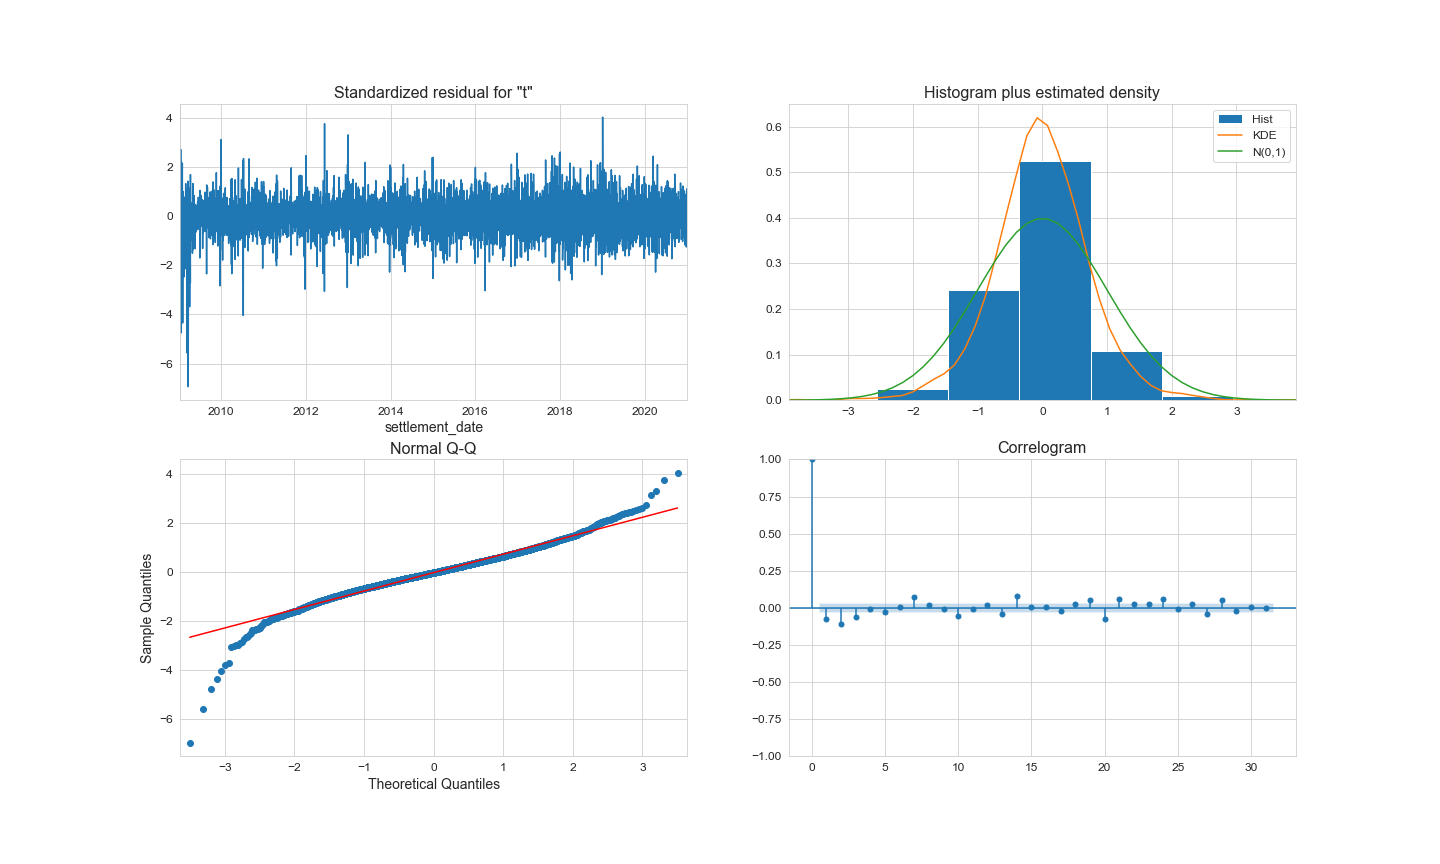


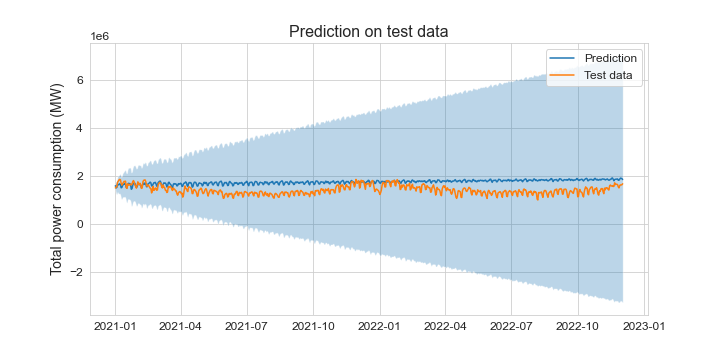

I ran the model, but as you can see, the code is commented out. The model took almost 25 minutes to run (the exact output of the original run is 0:24:27.022123), even though I set the maximum number of iterations to 25. I initially saved the entire model but it was a 10 GB file... Therefore, I decided to save the graphs only. 

Despite the runtime and the complexity of the model, it actually leads to a worse prediction since the mape value is 26.2 (the exact result is 26.17452577271045).

The reality is that none of the SARIMA models perform well. They don't capture the trend and the struggle to capture the yearly seasonality. Obviously, the parameters need to be refined, but the models take too long to run to choose the optimal parameters using [pdarima](https://pypi.org/project/pmdarima/) or a similar package.

<a id='xgboost'></a>

# XGboost

The second forecasting method I will use is XGBoost. It isn't a forecasting tool per se, but a regression tool. While traditional regression techniques struggle with time series forecasting, XGBoost does a great job as we will see. Also, XGBoost can use multiple features instead of just the electricity demand.

I was inspired to use XGBoost for time series forecasting after seeing a couple of Youtube videos ([video 1](https://www.youtube.com/watch?v=vV12dGe_Fho&t=3s) and [video 2](https://www.youtube.com/watch?v=z3ZnOW-S550&t=800s)) from [Rob Mulla](https://www.kaggle.com/robikscube).

### Simple XGBoost model
The first XGBoost model is a simple model for which some of the parameters are defined and the data is split into train and test sets. This model is fairly simple, but it's a great baseline

#### Training - test split
The first step is to split the data. I will split the data into train, test and hold-out set. The hold-out set will be used for independent evaluation of the model while the model is being trained. 

In [ ]:
threshold_date_1 = "06-01-2019"
threshold_date_2 = "06-01-2021"
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_data["tsd"].plot(ax=ax, label="Training set")
test_data["tsd"].plot(ax=ax, label="Test set")
hold_out_data["tsd"].plot(ax=ax, label="Hold-out set")
ax.axvline(threshold_date_1, color="k", ls="--")
ax.axvline(threshold_date_2, color="k", ls=":")
ax.set_title("Training-test split")
plt.legend();

In [ ]:
# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

# Prepare the training, testing and hold-out data
X_train = train_data[FEATURES]
y_train = train_data[TARGET]

X_test = test_data[FEATURES]
y_test = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES]
y_hold_out = hold_out_data[TARGET]

# Initialize and fit the XGBoost model
xgb_simple = xgb.XGBRegressor(
    n_estimators=500, 
    max_depth=3, 
    learning_rate=0.01, 
    early_stopping_rounds=50, 
#     tree_method="gpu_hist",
    random_state=43, 
)

xgb_simple.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_hold_out, y_hold_out)],
    verbose=100,
);


#### Feature importance

Since there are multiple parameters, we can check the importance of each of them as follows:

In [ ]:
feat_imp_1 = pd.DataFrame(
    data=xgb_simple.feature_importances_,
    index=xgb_simple.get_booster().feature_names,
    columns=["importance"],
)

feat_imp_1.sort_values("importance", ascending=True, inplace=True)

feat_imp_1.plot(kind="barh");

#### Forecast on test set

Once the model is trained, it can be used to predict the demand on the test set. 

In [ ]:
result_frame = y_test.to_frame()
result_frame["pred_xgb_simple"] = xgb_simple.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_xgb_simple"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Let's focus on a single week to see how the individual predictions perform compared to the test set:

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

As can be seen, the model struggles to capture the peaks and valleys. This is a similar behaviour as [@carlmcbrideellis](https://www.kaggle.com/carlmcbrideellis) in [his kernel](https://www.kaggle.com/code/carlmcbrideellis/multivariate-time-series-forecasting-linear-tree) about linear trees. Tree based estimators don't generalise well for time series forecasting. In the next section I will use grid search to see if tuning the model hyperparameters leads to a better prediction.

In [ ]:
mape_xgboost_simple = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_simple"]
)

rmse_xgboost_simple = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_simple"]))

print(
    "Mean Absolute Percentage Error of the simple model is: %.2f" % mape_xgboost_simple
)

print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_xgboost_simple
)

## XGBoost with Cross validation and Grid Search

The model above is a good starting point, but it's still underfitted to the data. One can run the model again and change the hyperparameters,but it isn't the right way to train a model if we want to avoid overfitting. This problem can be solved by using cross validation and grid search.

### Cross Validation for time series

The first step is to create the data split for cross validation. Luckily, sklearn includes the class `TimeSeriesSplit` that will get the job done. Let's split the data and see what it looks like:

In [ ]:
n_years_test = 1
tss = TimeSeriesSplit(n_splits=4, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, test_index in tss.split(df[df.index<threshold_date_1]):

    train = df.iloc[train_index]
    test = df.iloc[test_index]

    train["tsd"].plot(
        ax=axes[fold], label="Training set", title=f"Data Train-test split fold {fold}",
    )
    test["tsd"].plot(ax=axes[fold], label="Test set")
    axes[fold].axvline(test.index.min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

One can combine the cross validation technique for time series, called `TimeSeriesSplit` with GridSearchCV to find the best parameters for the XGBoost model.

For some reason, I kept getting a warning about the index of my timeseries being `pd.Int64Index`. Apparently, people are getting this error by simply using the xgboost package, as this [question on StackOverflow](https://stackoverflow.com/questions/71083866/pandas-int64index-fix-for-futurewarning) covers. I tried some of the suggested solutions, but it didn't work. 

While I'm not a fan of hiding errors, this one isn't likely to affect the project in the future. Therefore, I will simply ignore this error using the solution shared in this [StackOverflow entry](https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings).

In [ ]:
import warnings

def fxn():
    warnings.warn("FutureWarning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

warnings.filterwarnings("ignore")

It's worth noting that the previous model uses a simple XGBoost regressor object with the early stopping option set to 50 iterations, but I didn't know how to combine this function with `GridSearchCV`. Luckily, this topic is covered in this entry [in StackOverflow](https://stackoverflow.com/questions/42993550/gridsearchcv-xgboost-early-stopping).

In [ ]:
%%time

train_data.index = pd.Index(train_data.index)
test_data.index = pd.Index(test_data.index)

FEATURES_CV = [
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
    "lag1",
    "lag2",
    "lag3",
    "is_holiday",
]
TARGET = "tsd"

# Define train, test and hold-out set for the cv features
X_train_cv = train_data[FEATURES_CV]
y_train_cv = train_data[TARGET]

X_test_cv = test_data[FEATURES_CV]
y_test_cv = test_data[TARGET]

X_hold_out = hold_out_data[FEATURES_CV]
y_hold_out = hold_out_data[TARGET]


# Define fit parameters to allow early stopping in GridSearchCV
fit_params = {
    "early_stopping_rounds": 50,
    "eval_metric": "rmse",
    "eval_set": [[X_hold_out, y_hold_out]],
}

# Define estimator
estimator = xgb.XGBRegressor(
    base_score=0.5, 
    booster="gbtree",  
    learning_rate=0.01,
    tree_method="gpu_hist",
    random_state=43, 
)

# Define parameters to optimiser
param_search = {
    "max_depth": [3, 5], 
    "n_estimators": [350, 500, 650], 
    "subsample": [0.95, 0.8, 0.7],
}


# Create GridSearchCV object
xgb_search = GridSearchCV(
    estimator=estimator,
    cv=tss,
    param_grid=param_search,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

xgb_search.fit(X_train_cv, y_train_cv, verbose=500, **fit_params);

As one can see, it takes a long time to run each fold of the cross-validation. This can be sped up using the GPUs available on Kaggle, but that leads to an increase in runtime in the tasks carried out by CPUs as the number of CPUs is halved. 

In [ ]:
xgb_search.best_params_

In [ ]:
result_frame["pred_xgb_cv_gs"] = xgb_search.predict(X_test_cv)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test data")
ax.plot(
    result_frame.index,
    result_frame["pred_xgb_cv_gs"],
    "o",
    label="Prediction",
    alpha=0.5,
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_simple"
    ],
    "o",
    label="Prediction simple",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction cv gs",
)

ax.legend(loc="center", bbox_to_anchor=(1.1, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

After tuning some hyperparameters, XGBoost does a better job in capturing the daily seasonality, but it struggles to accurately predict the peaks and valleys.

In [ ]:
mape_xgboost_cv = mean_absolute_percentage_error(
    y_test, result_frame["pred_xgb_cv_gs"]
)

rmse_xgboost_cv = np.sqrt(mean_squared_error(y_test, result_frame["pred_xgb_cv_gs"]))
print(
    "Mean Absolute Percentage Error of the cross-validated model is: %.2f"
    % mape_xgboost_cv
)

print(
    "Root Mean Squared Error of the cross-validated model is: %.2f MW" % rmse_xgboost_cv
)

### Prediction into the future

Now that the best parameters have been found, the model can be fit using the entire dataset to then predict into the future. 

In [ ]:
X_all = df[FEATURES_CV]
y_all = df[TARGET]

xgb_best = xgb_search.best_estimator_
xgb_best.set_params(n_jobs=-1)
xgb_best.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
    verbose=100,
    early_stopping_rounds=50,
);

The next step is to build a dataframe that goes into the future:

In [ ]:
def settlement_period(df):
    """
    Determine settlement period using dataframe index date. Each settlement period
    equates to 30-minute interval.
    Settlement period equal to 0 corresponds with 00:00:00 and settlement period 48
    corresponds with 23:30:00

    Args:
        - df: time series dataframe containing dates in the future

    Returns:
        - df: time series dataframe with settlement period column
    """

    df = df.copy()

    settlement_period_array = (
        np.array(df.index.hour.to_list()) * 2 + np.array(df.index.minute.to_list()) / 30 + 1
    ).astype(int)


    df["settlement_period"] = settlement_period_array

    return df

In [ ]:
prediction_days = 210

future = pd.date_range(
    str(df.index.max())[0:10],
    df.index.max() + datetime.timedelta(days=prediction_days),
    freq="30min",
)

future_df = pd.DataFrame(index=future)
future_df = settlement_period(future_df)
future_df["is_future"] = True
df["is_future"] = False

# Create a dataframe containing the original data and the predict df
df_and_future = pd.concat([df, future_df])

# add features and lag
# lag values will change w.r.t original dataframe
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

# add bank holidays in future dataframe
df_and_future_wprediction = df_and_future.query("is_future").copy()

df_and_future_wprediction["settlement_date"] = df_and_future_wprediction.index.date
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["settlement_date"].apply(
    lambda x: pd.to_datetime(x) in holiday_dates_observed
)
df_and_future_wprediction["is_holiday"] = df_and_future_wprediction["is_holiday"].astype(int)

df_and_future_wprediction.tail()

As can be seen, the last rows of the new dataframe go into the future. 

Now, the XGBoost model can be used to predict into the future:

In [ ]:
df_and_future_wprediction["pred_xgboost"] = xgb_best.predict(
    df_and_future_wprediction[FEATURES_CV]
)


fig, ax = plt.subplots(figsize=(15, 5))
df_and_future_wprediction["pred_xgboost"].plot(figsize=(15, 5), style="-", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

<a id="linear_trees"></a>
# Linear Trees

Inspired by [@carlmcbrideellis](https://www.kaggle.com/carlmcbrideellis) and [his kernel on time series forecasting using linear trees](https://www.kaggle.com/code/carlmcbrideellis/multivariate-time-series-forecasting-linear-tree), I decided to try this package to predict electricity consumption. This [python package](https://github.com/cerlymarco/linear-tree) was created Marco Cerliani.  This is a python library to build Model Trees with Linear Models at the leaves.

Out of the different models included in this library, I will use the Linear Boosting model. As stated [in the documentation](https://github.com/cerlymarco/linear-tree), Linear Boosting is com:

* A linear model is trained on the initial dataset to obtain predictions
* The residuals of the previous step are modeled with a decision tree using all the available features
* The tree identifies the path leading to highest error (i.e. the worst leaf)
* The leaf contributing to the error the most is used to generate a new binary feature to be used in the first stage
* The iterations continue until a certain stopping criterion is met


In [ ]:
%%time
linear_boost = LinearBoostRegressor(
    base_estimator=LinearRegression(n_jobs=-1),
    n_estimators = 350, 
    max_depth = 6,
    random_state = 43,
)

linear_boost.fit(X_train, y_train)

result_frame["pred_linear_boost"] = linear_boost.predict(X_test)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_linear_boost"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_xgb_cv_gs"
    ],
    "o",
    label="Prediction XGBoost",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_linear_boost"
    ],
    "d",
    label="Prediction Linear Boost",
)

ax.legend(loc="center", bbox_to_anchor=(1.15, 0.5))

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

It seems that Linear Boosting does a better job in predicting the peaks and valleys, but it struggles to capture the transition to those peaks and valleys. It shows "discontinuities", such as on 2021-02-05 where the prediction goes from almost 45,000 MW to slightly more than 40,000 MW in just half an hour. I presume the model exhibits this behaviour because it's underfitted to the training data. Unfortunately, it already takes more than 13 minutes to run a simple model.

In [ ]:
mape_linear_boost = mean_absolute_percentage_error(
    y_test, result_frame["pred_linear_boost"]
)
rmse_linear_boost = np.sqrt(mean_squared_error(y_test, result_frame["pred_linear_boost"]))

print(
    "Mean Absolute Percentage Error of the Linear Boosted model is: %.2f"
    % mape_linear_boost
) 
print(
    "Root Mean Squared Error of the simple models is: %.2f MW" % rmse_linear_boost
)

<a id='prophet'></a>

# Prophet

[Prophet](https://facebook.github.io/prophet/docs/quick_start.html) is Facebook's own timer-series forecasting method based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. I will create different Prophet models in this section and compare the performance of each of them.

One slight issue I encountered when running the Prophet models is the fact that cmdstanpy printed information messages when the model started and finished training, such as `20:46:37 - cmdstanpy - INFO - Chain [1] start processing`. Since I run the models before committing this version of the notebook, I will hide those information messages. Apparently, I'm not the first one who's encountered this problem and, as usual, [StackOverflow](https://stackoverflow.com/questions/66667909/stop-printing-infocmdstanpystart-chain-1-infocmdstanpyfinish-chain-1) has the solution.

In [ ]:
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

As stated in the [Prophet API](https://facebook.github.io/prophet/docs/quick_start.html), the first step is to rename the dataframe colums to stick to the expected notation from the model.

In [ ]:
train_data_prophet = y_train.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
test_data_prophet = y_test.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
hold_out_data_prophet = y_hold_out.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})
all_data_prophet = y_all.to_frame() \
                            .reset_index() \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})


Since our model is additive (this is the default option for Prophet) and Prophet can deal with multiple seasonalities, the prediction dataframe includes multiple values, all of them with the upper and lower bounds of their confidence interval.

As per the suggestion of [The Devastator](https://www.kaggle.com/thedevastator), a Kaggle grandmaster, in [his comment](https://www.kaggle.com/code/albertovidalrod/uk-electricity-consumption-prediction-time-series/comments#2093356) I set a seed for reproducibility in the XBoost models (easy to do by defining `random_state`) and I did the same for Prophet. However, there isn't a model parameter to do it. The Prophet team address this in [an answer of one of the GitHub issues](https://github.com/facebook/prophet/issues/1124#issuecomment-812904897), which is what I've done in the cell above by using `np.random.seed(43)` before running `model.predict()`

In [ ]:
%%time
prophet_model = Prophet()
prophet_model.fit(train_data_prophet)

np.random.seed(43)
prophet_predict_df = prophet_model.predict(test_data_prophet)
prophet_predict_df.head()

Prophet also includes a function that allows us to easily visualise the prediction component (trends and seasonalities) together with the confidence intervals.

In [ ]:
prophet_model.plot_components(prophet_predict_df);

We can now plot the prediction on the test set:

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set - week")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

Similarly to the analysis I performed on the prediction results using XGBoost, one can focus on a single week to check how the individual predictions compare with the true data.

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xbound(lower=threshold_date_1, upper="06-08-2019")
ax.set_ylim(bottom=10000, top=40000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("First week of forecast vs actual data")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The above graph belongs to the first week of the test set. It does a fairly good job, but more importantly, it includes the confidence intervals. 

As we saw in the overall prediction comparison, the confidence intervals widen as time goes on. Let's have a look at what the comparison looks like some months after the beginning of the test set:

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xbound(lower=begin, upper=end)
ax.set_ylim(bottom=10000, top=60000)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Comaprison of forecast vs actual data after several months")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

We can now see more clearly how the confidence interval widens.

Finally, let's have a look at the MAPE value:

In [ ]:
%%time
mape_prophet_simple = mean_absolute_percentage_error(
    y_test, prophet_predict_df["yhat"]
)
rmse_prophet_simple = np.sqrt(mean_squared_error(y_test, prophet_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the simple Prophet model is: %.2f"
    % mape_prophet_simple
)
print(
    "Root Mean Squared Error of the simple Prophet models is: %.2f MW" % rmse_prophet_simple
)

## Prophet with holidays

One of Prophet's strong suits is the ability to include holidays in the prediction. This is particularly useful to me as I have already gathered information about the bank holidays in the UK. [Prophet's API](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events) includes a section describing how to implement it. Basically, one needs to create a dataframe containing the days and the name of the holiday, with the columns named `ds` and `holiday`.

In [ ]:
holiday_df = pd.DataFrame(data={"ds": holiday_dates_observed, "holiday": holiday_names_observed})
holiday_df.head()

In [ ]:
prophet_hol_model = Prophet(holidays=holiday_df)
prophet_hol_model.fit(train_data_prophet)

np.random.seed(43)
prophet_hol_predict_df = prophet_hol_model.predict(test_data_prophet)
prophet_hol_model.plot_components(prophet_hol_predict_df);

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

prophet_hol_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.legend(bbox_to_anchor=(1.15, 0.5), loc="center", ncol=1)

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The prediction on the test set seems to be very similar to the previous Prophet model. This is the expected behaviour as the new model parameter should only affect the holidays. Therefore, let's focus on a period with multiple holidays, such as the period between December 23rd and December 28th (two bank holidays), and compare the two Prophet models:

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xlim(left="12-23-2019", right="12-28-2019")
ax.set_ylim(bottom=12500, top=47500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model without holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");


fig, ax = plt.subplots(figsize=(15,5))

prophet_model.plot(prophet_hol_predict_df, ax=ax, include_legend=True)
ax.scatter(y_test.to_frame().index, y_test.to_frame()["tsd"], color='r', label="Test data")
ax.set_xlim(left="12-23-2019", right="12-28-2019")
ax.set_ylim(bottom=12500, top=47500)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);
ax.set_title("Christmas week 2020 - Model with holiday")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The prediction is way more accurate for the second model, proving that this functionality works, especially when many holidays are fed to the model and it can learn the pattern on those days. 

It's interesting that right before and right after the holiday there's a steep change (either upwards or downwards) in the value to adjust the value to "non-holiday". The model could be improved if it picked up the trend more slowly. 

In [ ]:
mape_prophet_holiday = mean_absolute_percentage_error(
    y_test, prophet_hol_predict_df["yhat"]
)
rmse_prophet_holiday = np.sqrt(mean_squared_error(y_test, prophet_hol_predict_df["yhat"]))
print(
    "Mean Absolute Percentage Error of the holiday Prophet model is: %.2f"
    % mape_prophet_holiday
)
print(
    "Root Mean Squared Error of the Prophet (with holiday) model is: %.2f MW" % rmse_prophet_holiday
)

## Prophet with cross-validation and "grid search"

Similarly to implementing cross-validation and grid search with XGBoost, I want to use these techniques together with Prophet to generate better predictions. [Prophet's API](https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation) includes a section that covers this. Unfortunately, I didn't manage to use the cross validation class because it took too long to run. In case you're interested in that class, the API's example is as follows:

`from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')`

It's worth noting that the model needs to be fitted first and the `cross_validation` object can be used to compute the metrics from each fold.

Also, since each model takes long to be fitted (up to 2 miniutes), I chose only 2 splits, which isn't a recommended practice, especially given that this is a large dataset,  


In [ ]:
n_years_test = 2
tss_prophet = TimeSeriesSplit(n_splits=2, test_size=48 * 365 * n_years_test, gap=48)

fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

fold = 0
for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
    train_data = y_train.to_frame() \
                        .reset_index() \
                        .iloc[train_index] \
                        .rename(columns={"settlement_date": "ds", "tsd": "y"})

    test_data = y_train.to_frame() \
                    .reset_index() \
                    .iloc[test_index] \
                    .rename(columns={"settlement_date": "ds", "tsd": "y"})
    
    axes[fold].plot(train_data["ds"], train_data["y"], label="Training set")
    axes[fold].plot(test_data["ds"], test_data["y"], label="Test set")
    axes[fold].axvline(test_data["ds"].min(), color="k", ls="--")
    axes[fold].legend(loc="center", bbox_to_anchor=(1.075, 0.5))

    axes[fold].set_title("Prediction on test set - week")
    axes[fold].set_ylabel("Energy Demand (MW)")
    axes[fold].set_xlabel("Date");
    fold += 1

In [ ]:
%%time

# Define the parameter grid for the Prophet model
param_grid = {"changepoint_prior_scale": [0.05], "seasonality_prior_scale": [2.5, 10]}

# Create all possible combinations of the parameter grid
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

rmse_cv_gs = []

for params in all_params:
    rmse_cv = []
    
    for train_index, test_index in tss_prophet.split(df[df.index<threshold_date_1]):
        train_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[train_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        test_data = y_train.to_frame() \
                            .reset_index() \
                            .iloc[test_index] \
                            .rename(columns={"settlement_date": "ds", "tsd": "y"})

        model = Prophet(**params, holidays=holiday_df)
        model.fit(train_data)

        prediction = model.predict(test_data)
        mse_val = mean_squared_error(test_data["y"], prediction["yhat"])
        rmse_cv.append(np.sqrt(mse_val))
    
    rmse_cv_gs.append(np.mean(rmse_cv))
    
grid_search_results = pd.DataFrame(all_params)
grid_search_results['rmse'] = rmse_cv_gs

grid_search_results

In this example, there are only two hyperparameter combinations and it's fairly straightforward to identifty the 

In [ ]:
best_params = all_params[np.argmin(rmse_cv_gs)]
print(best_params)

In [ ]:
# Create Prophet using the best parameters from the grid search
prophet_best = Prophet(**best_params, holidays=holiday_df)
prophet_best.fit(train_data_prophet)

prophet_best_predict_df = prophet_best.predict(test_data_prophet)

# Compute MAPE value
mape_prophet_cv_gs = mean_absolute_percentage_error(
    y_test, prophet_best_predict_df["yhat"]
)
rmse_prophet_cv_gs = np.sqrt(
    mean_squared_error(y_test, prophet_best_predict_df["yhat"])
)
print(
    "Mean Absolute Percentage Error of the best-parameters Prophet model is: %.2f"
    % mape_prophet_cv_gs
)
print(
    "Root Mean Squared Error of the Prophet (with cross-validation) model is: %.2f MW" % rmse_prophet_cv_gs
)

## Prediction into the future

Once the best set of parameters has been found, we can use that model into the future. To get the most of our model, we will first fit the entire dataset and then make the future predictions.

Prophet includes its own function to create a dataframe that goes into the future, `model.make_future_model()`, which makes things even easier. 

In [ ]:
# Fit a new model using all the data as training data
prophet_future_model = Prophet(**best_params, holidays=holiday_df)
prophet_future_model.fit(all_data_prophet)

# Make predictions on future dataframe
prophet_future = prophet_future_model.make_future_dataframe(periods=210*24, freq="H", include_history=False)
prophet_fut_forecast = prophet_future_model.predict(prophet_future)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(prophet_fut_forecast["ds"], prophet_fut_forecast["yhat"])

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Future demand prediction");

Finally, one can compare the future predictions from the different models since both models span for the same number of days.

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(
        df_and_future_wprediction.index, 
        df_and_future_wprediction["pred_xgboost"], 
        label = "XGBoost prediction"
        )
ax.plot(
        prophet_fut_forecast["ds"], 
        prophet_fut_forecast["yhat"], 
        label = "Prophet prediction", 
        alpha = 0.75
        )

ax.set_xlabel("Date")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Prediction comparison")

ax.legend(bbox_to_anchor=(1.1, 0.5), loc="center", ncol=1);

<a id='lstm'></a>
# LSTM and deep LSTM

Previous methods use statistical models (SARIMA and prophet) or gradient boosted trees (XGBoost and Linear Trees) as the foundation of method. It's time now to move on to recurrent neural networks to predict electricity demand. I will use LSTM as the foundation unit. It's well known that LSTM overcome the drawbacks of RNNs. 

I will create two different models:
* LSTM model: a single layer of LSTM units. 
* Deep LSTM is a variation of LSTM where multiple layers of LSTM units are stacked to produce better predictions. This is the preferred apporach nowadays, but I will still explore what a single layer of LSTM units can do.

## LSTM



In [ ]:
# Define rmse metric for keras to use as a loss function
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

Although we had split the data before, LSTM require the input data to be scaled in order to make accurate predictions. Therefore, one needs to split the data again and scale it afterwards. The reason I need to split the data again is because I will concatenate the outcome variable (electricity demand) with the indepenent features. This is necessary to scale all the data using a single scaler object. Alterntaively, I could use one scaler object for the features and one scaler object for the predicted variable, but I decided to use only one scaler for all the data.

In [ ]:
train_data = df.loc[df.index < threshold_date_1]
test_data = df.loc[(df.index >= threshold_date_1) & (df.index < threshold_date_2)]
hold_out_data = df.loc[df.index >= threshold_date_2]

# Define the features and target variable
FEATURES = [
    "is_holiday",
    "settlement_period",
    "day_of_month",
    "day_of_week",
    "day_of_year",
    "quarter",
    "month",
    "year",
    "week_of_year",
]
TARGET = "tsd"

FEATURES_TARGET = FEATURES.copy()
FEATURES_TARGET.append(TARGET)
train_data_keras = train_data[FEATURES_TARGET]
test_data_keras = test_data[FEATURES_TARGET]

scaler = MinMaxScaler(feature_range=(0,1))
train_data_keras_s = scaler.fit_transform(train_data_keras.values)
test_data_keras_s = scaler.transform(test_data_keras.values)

X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(FEATURES))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(FEATURES))
)
y_test_keras = test_data_keras_s[:,-1]

In [ ]:
# Define a random seed for reproducibility
tf.random.set_seed(221)

# Create and compite neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "./models_data/simple_lstm/checkpoint",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

Once the neiureal network has been trained, we can make predictions on the test set. Remember that we had to scale all the data to fit the mode. thus, we first need to inverse transform the output before we can use for plotting or to calculate the performance with respect to the original electricity demand values.

In [ ]:
# Prediction on test set
pred_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_lstm"] = results_lstm[:,-1]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

It seems that the overall prediction is good, but it struggles to correctly identify the maximum and minimum values. Let's focus on a two-week period:

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

As you can see, the above figure is an actual line plot instead of scatter plot and this isn't a coincidence.The reason I did it is to verify that output of the LSTM model isn't a lagged version of the actual data. I've encountered many notebooks where the accuracy of the LSTM prediction is really high, but as [this notebook](https://www.kaggle.com/code/carlmcbrideellis/lstm-time-series-stock-price-prediction-fail) from one Kaggle grandmaster ([Carl](https://www.kaggle.com/carlmcbrideellis)) shows, sometimes the very high accuracy is the result of the LSTM not finding any meaningful patterns and simply ouputing a lagged version of the original data.

This isn't the case here. The prediction isn't great and it shows that the model can predict the general shape of the pattern, which might actually be tha average pattern, but it could be better. It can be seen that the prediction for Monday to Thursday (for reference, 2021-02-01 is a Monday) is almost the same, and the prediction starts decreasing on Friday and it reaches the lowest values on Sunday. 

In [ ]:
mape_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_lstm"]
)

rmse_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_lstm"]))

print(
    "Mean Absolute Percentage Error of the LSTM model is: %.2f" % mape_lstm
)

print(
    "Root Mean Squared Error of the LSTM model is: %.2f MW" % rmse_lstm
)

Being honest, the prediction using a single layer of LSTM units is better than I expected. Let's see how much better the deep LSTM model is.

## Deep LSTM

In [ ]:
# Create and compile neural network
model = Sequential()
model.add(LSTM(256, input_shape=(X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = root_mean_squared_error, optimizer="adam")

# Define callbacks
monitor_param = root_mean_squared_error
mode="min"
early_stopping = EarlyStopping(monitor=root_mean_squared_error, patience=8, verbose=0, mode=mode)
checkpoint_save = ModelCheckpoint(
    "./models_data/deep_lstm/checkpoint",
    save_weights_only=True,
    monitor=monitor_param,
    mode=mode,
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode
)

# Fit model
history_deep_lstm = model.fit(
    X_train_keras,
    y_train_keras,
    epochs=100,
    batch_size=144,
    validation_data=(X_test_keras, y_test_keras),
    callbacks=[early_stopping, checkpoint_save, reduce_lr_loss]
)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

Similarly to the previous LSTM model, the output needs to inverse transformed.

In [ ]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
result_frame["pred_deep_lstm"] = results_deep_lstm[:,-1]

Let's check the predictions:

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(result_frame.index, result_frame["tsd"], "o", label="Test set")
ax.plot(result_frame.index, result_frame["pred_deep_lstm"], "o", label="Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

It seems like the model is much better at predicting the maximum daily values and it has improved its performance over the winter period, but somehow the summer predictions look worse... Again, the maximum values are better predicted, but the minimum values, especially for 2020 are way off.

In [ ]:
begin = "02-01-2021"
end = "02-14-2021"

fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)]["tsd"],
    "-o",
    label="Test set",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_lstm"
    ],
    "-s",
    label="LSTM",
)

ax.plot(
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)].index,
    result_frame.loc[(result_frame.index > begin) & (result_frame.index < end)][
        "pred_deep_lstm"
    ],
    "-d",
    label="Deep LSTM",
)

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set - Two weeks")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

The above two-week period shows that the deep LSTM network performs better than the simple LSTM network. It seems like the shape of the daily pattern is almost perfect, although the amplitude isn't correct. 

However, this two-week period belongs to the winter season, which as seen above, it seems much better for the deep LSTM model. MAPE and RMSE values will help understand if the overall performance of the deep LSTM network is actually better.

In [ ]:
mape_deep_lstm = mean_absolute_percentage_error(
    y_test, result_frame["pred_deep_lstm"]
)

rmse_deep_lstm = np.sqrt(mean_squared_error(y_test, result_frame["pred_deep_lstm"]))

print(
    "Mean Absolute Percentage Error of the deep LSTM model is: %.2f" % mape_deep_lstm
)

print(
    "Root Mean Squared Error of the deep LSTM model is: %.2f MW" % rmse_deep_lstm
)

Overall, it improves the results from the simple LSTM recurrent network, but I expected a greater improvement given that there are three layers of LSTM units.

# Summary of the results and key insights



In [ ]:
summary_df = pd.DataFrame(
    {
        "XGBoost - Simple": [mape_xgboost_simple, rmse_xgboost_simple],
        "XGBoost - CV & GS": [mape_xgboost_cv, rmse_xgboost_cv],
        "Linear Boost": [mape_linear_boost, rmse_linear_boost],
        "Prophet - Simple": [mape_prophet_simple, rmse_prophet_simple],
        "Prophet - Holiday": [mape_prophet_holiday, rmse_prophet_holiday],
        "Prophet - CV & GS": [mape_prophet_cv_gs, rmse_prophet_cv_gs],
        "LSTM": [mape_lstm, rmse_lstm],
        "Deep LSTM": [mape_deep_lstm, rmse_deep_lstm],
        "Metric": ["MAPE", "RMSE"]
    }
)

summary_df.set_index("Metric", inplace=True)

summary_df.style.format('{:.2f}') 

**XGBoost** has proven why in the recent years it has become the go-to algorithm for many problems. A simple XGBoost model and a single train-test split results in a MAPE value of 9.2%. Surely the model needs more work and tuning, but a couple of lines of code gave me a very accurate prediction I couldn't get that accuracy level with SARIMA after spending hours tweaking the parameters. 

While a single train-test split isn't the optimal way to train a model, the combination of cross-validation and grid search with a hold-out set for independent evaluation is the right way to do things. This option yields an error of 7.3%, which is a great value since I only tuned a few hyperparameters.

**Linear Boosting** has proven to be a great alternative to Gradient Boosted Trees for time-series forecasting and it addresses the main problems that GBT have. This model has a great potential, but it's slow tp run. Unfortunately, it cannot be sped up using GPUs and multi-core CPU is the only way to speed up the computations. 

**Prophet** has also proven why it's one of the go-to options for time-series forecasting. The performance is slightly worse than XGBoost, but I barely tuned the hyperparamters. The only downside from this model is the execution time as it takes on average 3 minutes to train a model. As a result, a simple cross validation (2 folds) and grid search (only two combinations) results in 12 minutes.  

**LSTM** recurrent networks show a great performance and the ability to use GPUs to speed up the training makes them a very atractive option. I'm glad I didn't jump stratight into this approach, which has become the go-to approach for time-series forecasting, but it has proven why it's such a great choice.

With regards to the **SARIMA** models, they can't capture the complexity of the time series. I soon realised I couldn't use the data set with two measurements per hour. I had to resample it using a daily frequency, which isn't ideal for this problem. However, I tried to optimised the parameters to capture the yearly trend and make a reasonable prediction, but I didn't managed. I don't know if I should a different strategy to tune the parameters or the model simply isn't suitable to this application. 

In previous notebooks versions, I recommended XGBoost for this prediction task given the accuracy and runtime. However, as I learn more about time-series forecasting and the problems Gradient Boosting Trees have, I'm more hesitant when it comes to choosing XGBoost for this task. Although I would like to explore Prophet and Linear Boosting more before making a recommendation. 

# Next steps

While XGBoost offers a great performance, I don't know if this is the best tool to forecast electricity demand. In order to make sure I develop the best model, I need to carry out several tasks:
* Better strategy of SARIMA parameter tuning
    * Grid Search will not work given the current runtime
    * Try adding exogenous parameters
* Increase the number of parameters tuned in the Prophet model
    * This needs a faster way to fit models or at least way of efficiently parallelising the computations (I tried parallelising and it resulted in only a 50 s gain)
* Explore different "look back" strategies for the LSTM recurrent networks
* Use a different train-test split. While the seasonality is the same year after year, the minimum and maximum values of early years are higher than for the latest years.